# Group-Level Permutation Importance for AttentionMLP

Measures what the fitted model actually relies on — no retraining.
For each semantic feature group, simultaneously shuffle all member features
across players within each (game_id, turn) and measure Δ log-loss.
Then stratify by **victory type** and **game phase**.

In [87]:
import sys
sys.path.insert(0, '../models')   # from utils.xxx, from models.xxx
sys.path.append('..')              # from plot_utilities (lower priority)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.auto import tqdm

from plot_utilities import setup_notebook_display
setup_notebook_display(figsize=(12, 6))

## Load model + data → GPU tensors

In [88]:
from utils.model_registry import load_model
from utils.data_utils import load_and_prepare_base_data

# Load fitted model (weights + standardization params)
model = load_model("../models/output/attention_mlp_model")
MODEL_FEATURES = list(model.selected_features_)
device = model.device
print(f"Device: {device}")
print(f"Model features ({len(MODEL_FEATURES)}): {MODEL_FEATURES}")

Model loaded from ..\models\output\attention_mlp_model (AttentionMLPPredictor)
Device: cuda
Model features (24): ['science_adj', 'culture_adj', 'tourism_adj', 'gold_adj', 'food_adj', 'production_adj', 'military_adj', 'faith_adj', 'population', 'cities', 'votes', 'minor_allies', 'technologies_gap', 'policies_gap', 'highest_war_weariness', 'active_wars', 'truces', 'defensive_pacts', 'friendships', 'happiness_percentage', 'religion_percentage', 'military_utilization', 'turn_progress', 'score_ratio']


In [89]:
# Run full feature-engineering pipeline, keeping raw/adj columns the model needs
df = load_and_prepare_base_data("../turn_data.csv", keep_variants=True, filter_zero_score=False)

# Join victory type
panel = pd.read_csv("../panel_data.csv", usecols=["game_id", "victory_type"]).drop_duplicates("game_id")
df = df.merge(panel, on="game_id", how="left")

# Sort for reshape — every 8 consecutive rows = one (game_id, turn) group
df = df.sort_values(['game_id', 'turn', 'player_id']).reset_index(drop=True)

# Verify uniform group size
group_sizes = df.groupby(['game_id', 'turn']).size()
P = group_sizes.iloc[0]
assert (group_sizes == P).all(), f"Non-uniform group sizes: {group_sizes.value_counts().to_dict()}"
N_GROUPS = len(group_sizes)
N_FEATURES = len(MODEL_FEATURES)
print(f"Groups: {N_GROUPS:,}  |  Players/group: {P}  |  Features: {N_FEATURES}")

d:\Cache\Onedrive - Arizona\OneDrive - University of Arizona\Vox Deorum\nlp-2026-tiny-4player\analysis\performance\..\plot_utilities.py:829: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Loaded 1874632 records from 551 games
Groups: 234,329  |  Players/group: 8  |  Features: 24


In [90]:
# Standardize with the model's saved μ/σ, then reshape to (n_groups, P, 24)
Xmat = df[MODEL_FEATURES].to_numpy(dtype=np.float32)
Xmat = model._standardize_apply(Xmat)
X_tensor = torch.tensor(Xmat.reshape(N_GROUPS, P, N_FEATURES), device=device)

mask = torch.ones(N_GROUPS, P, dtype=torch.bool, device=device)
y_tensor = torch.tensor(
    df['is_winner'].to_numpy(dtype=np.float32).reshape(N_GROUPS, P), device=device
)

# Raw turn_progress for phase binning (constant within group → take first player)
tp_raw = df['turn_progress'].to_numpy().reshape(N_GROUPS, P)[:, 0]

# Victory type per group (constant within group → take first player)
vtype_per_group = df['victory_type'].values.reshape(N_GROUPS, P)[:, 0]

print(f"X_tensor: {X_tensor.shape}  |  dtype: {X_tensor.dtype}  |  device: {X_tensor.device}")

X_tensor: torch.Size([234329, 8, 24])  |  dtype: torch.float32  |  device: cuda:0


In [91]:
# Baseline forward pass
model.model.eval()
with torch.no_grad():
    baseline_logits = model._forward_inference(X_tensor, mask)
    baseline_logits = baseline_logits.masked_fill(~mask, float('-inf'))
    baseline_probs = torch.softmax(baseline_logits, dim=1)

print(f"Baseline mean prob: {baseline_probs.mean().item():.4f}")
print(f"Baseline prob range: [{baseline_probs.min().item():.6f}, {baseline_probs.max().item():.6f}]")

Baseline mean prob: 0.1250
Baseline prob range: [0.000040, 0.999068]


In [92]:
# Pre-compute stratification masks (on device)
VICTORY_TYPES = sorted(set(vtype_per_group) - {None, np.nan, 'nan'})
vtype_masks = {vt: torch.tensor(vtype_per_group == vt, device=device) for vt in VICTORY_TYPES}
print("Victory types:", {vt: int(m.sum()) for vt, m in vtype_masks.items()})

PHASE_LABELS = ['Early', 'Mid', 'Late']
phase_idx = np.digitize(tp_raw, bins=[0.33, 0.66])  # 0=early, 1=mid, 2=late
phase_masks = {label: torch.tensor(phase_idx == i, device=device)
               for i, label in enumerate(PHASE_LABELS)}
print("Phases:", {p: int(m.sum()) for p, m in phase_masks.items()})

Victory types: {'Cultural': 75283, 'Diplomatic': 76727, 'Domination': 13788, 'Science': 61526, 'Time': 7005}
Phases: {'Early': 77156, 'Mid': 77255, 'Late': 79918}


## Permutation groups

In [93]:
PERMUTATION_GROUPS = {
    'science':    ['science_adj', 'technologies_gap'],
    'culture':    ['culture_adj', 'tourism_adj', 'policies_gap'],
    'economy':    ['gold_adj', 'production_adj'],
    'growth':     ['cities', 'food_adj', 'population'],
    'religion':   ['faith_adj', 'religion_percentage'],
    'influence':  ['votes', 'minor_allies', 'defensive_pacts', 'friendships'],
    'war':        ['military_adj', 'military_utilization', 'active_wars', 'truces'],
    'welfare':    ['happiness_percentage', 'highest_war_weariness'],
    'score':      ['score_ratio'],
    # 'time':       ['turn_progress']
}

# Map feature names → column indices in X_tensor
feat_to_idx = {f: i for i, f in enumerate(MODEL_FEATURES)}
GROUP_INDICES = {
    name: [feat_to_idx[f] for f in feats]
    for name, feats in PERMUTATION_GROUPS.items()
}

for name, feats in PERMUTATION_GROUPS.items():
    print(f"  {name:12s}  {feats}")

  science       ['science_adj', 'technologies_gap']
  culture       ['culture_adj', 'tourism_adj', 'policies_gap']
  economy       ['gold_adj', 'production_adj']
  growth        ['cities', 'food_adj', 'population']
  religion      ['faith_adj', 'religion_percentage']
  influence     ['votes', 'minor_allies', 'defensive_pacts', 'friendships']
  war           ['military_adj', 'military_utilization', 'active_wars', 'truces']
  welfare       ['happiness_percentage', 'highest_war_weariness']
  score         ['score_ratio']


## GPU-vectorized permutation + Δ log-loss

In [94]:
def permute_features(X_base, feat_indices):
    """Shuffle feat_indices: swap group blocks, then shuffle players within.

    Step 1 — group swap: each group gets another group's feature values
             (all 8 players together, preserving within-group correlations).
    Step 2 — player shuffle: randomize which player gets which position's
             values, breaking any positional bias from the donor group.
    """
    X_perm = X_base.clone()
    idx = torch.tensor(feat_indices, device=X_base.device)
    G, P, _ = X_base.shape
    # Step 1: swap entire group blocks
    group_perm = torch.randperm(G, device=X_base.device)
    swapped = X_base[group_perm][:, :, idx]           # (G, P, F)
    # Step 2: shuffle player ordering within each group
    player_perm = torch.argsort(torch.rand(G, P, device=X_base.device), dim=1)
    expanded = player_perm.unsqueeze(-1).expand_as(swapped)
    X_perm[:, :, idx] = swapped.gather(1, expanded)
    return X_perm


def element_log_loss(probs, y, eps=1e-7):
    """Per-element binary log-loss on GPU.  Returns (G, P) tensor."""
    p = probs.clamp(eps, 1 - eps)
    return -(y * p.log() + (1 - y) * (1 - p).log())


baseline_ll = element_log_loss(baseline_probs, y_tensor)  # compute once
print(f"Baseline log-loss: {baseline_ll.mean().item():.6f}")

Baseline log-loss: 0.254348


In [95]:
N_REPEATS = 30


def run_permutation_importance(group_name, n_repeats=N_REPEATS):
    """Run permutation importance for one feature group.

    Returns list of dicts with Δ log-loss aggregated by
    overall / victory type / game phase.
    """
    feat_idx = GROUP_INDICES[group_name]
    rows = []

    for rep in range(n_repeats):
        X_perm = permute_features(X_tensor, feat_idx)

        with torch.no_grad():
            logits = model._forward_inference(X_perm, mask)
            logits = logits.masked_fill(~mask, float('-inf'))
            perm_probs = torch.softmax(logits, dim=1)

        # Δ log-loss per element, then aggregate
        perm_ll = element_log_loss(perm_probs, y_tensor)
        dll = perm_ll - baseline_ll  # (G, P)

        # Overall
        rows.append(dict(group=group_name, repeat=rep,
                         stratum='Overall', delta_ll=dll.mean().item()))

        # Per victory type  (mean across groups × players for that vtype)
        for vt, vmask in vtype_masks.items():
            vals = dll[vmask]          # (n_vt_groups, P)
            rows.append(dict(group=group_name, repeat=rep,
                             stratum=vt, delta_ll=vals.mean().item()))

        # Per game phase
        for phase, pmask in phase_masks.items():
            vals = dll[pmask]
            rows.append(dict(group=group_name, repeat=rep,
                             stratum=phase, delta_ll=vals.mean().item()))

    return rows

## Full loop

In [96]:
all_results = []  # already computed above

for group_name in tqdm(PERMUTATION_GROUPS, desc='Feature groups'):
    all_results.extend(run_permutation_importance(group_name))

results_df = pd.DataFrame(all_results)
print(f"Collected {len(results_df):,} rows  "
      f"({results_df['group'].nunique()} groups × {N_REPEATS} repeats × "
      f"{results_df['stratum'].nunique()} strata)")

Feature groups: 100%|██████████| 9/9 [00:31<00:00,  3.53s/it]

Collected 2,430 rows  (9 groups × 30 repeats × 9 strata)


## Results

In [97]:
# Overall importance ranking
overall = results_df[results_df['stratum'] == 'Overall'].copy()
overall_agg = (overall.groupby('group')['delta_ll']
               .agg(mean='mean', se=lambda x: x.std() / np.sqrt(len(x)))
               .sort_values('mean', ascending=False))
overall_agg['ci95'] = overall_agg['se'] * 1.96

group_order = overall_agg.index.tolist()  # reuse for all plots
overall_agg.style.format({'mean': '{:.6f}', 'se': '{:.6f}', 'ci95': '{:.6f}'})

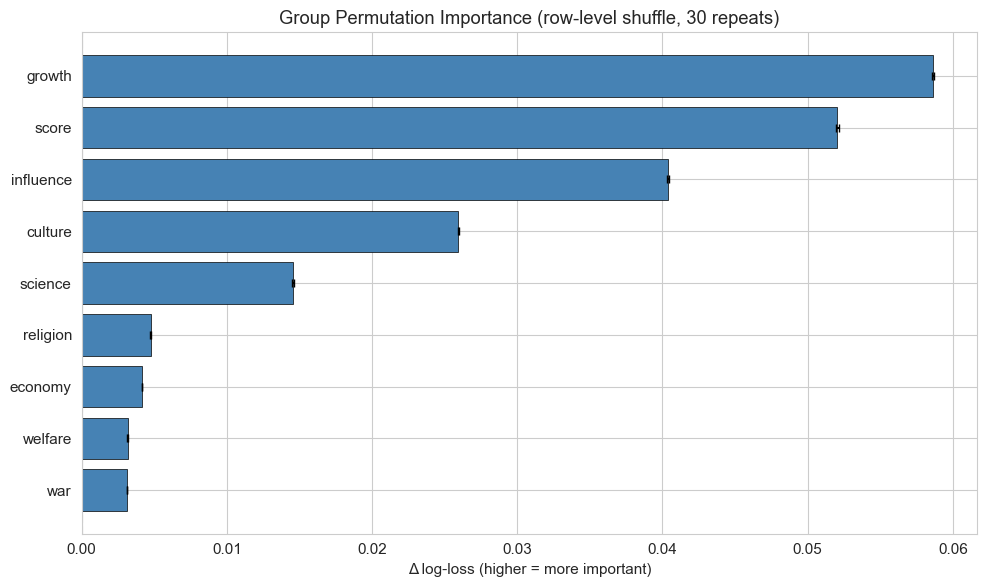

In [98]:
# Bar chart: overall importance
fig, ax = plt.subplots(figsize=(10, 6))

data = overall_agg.loc[group_order[::-1]]  # ascending for horizontal bars
ax.barh(data.index, data['mean'], xerr=data['ci95'],
        capsize=3, color='steelblue', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Δ log-loss (higher = more important)')
ax.set_title('Group Permutation Importance (row-level shuffle, 30 repeats)')
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

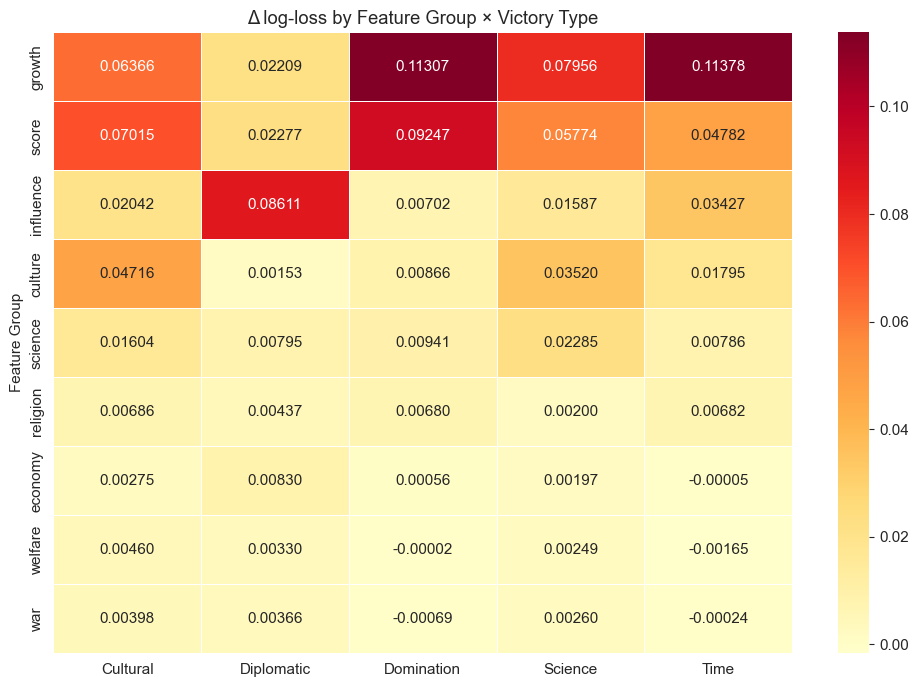

In [99]:
# Heatmap: group × victory type
vtype_df = results_df[results_df['stratum'].isin(VICTORY_TYPES)].copy()
vtype_pivot = (vtype_df.groupby(['group', 'stratum'])['delta_ll']
               .mean().unstack('stratum'))
vtype_pivot = vtype_pivot.loc[group_order, VICTORY_TYPES]

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(vtype_pivot, annot=True, fmt='.5f', cmap='YlOrRd',
            linewidths=0.5, ax=ax)
ax.set_title('Δ log-loss by Feature Group × Victory Type')
ax.set_ylabel('Feature Group')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

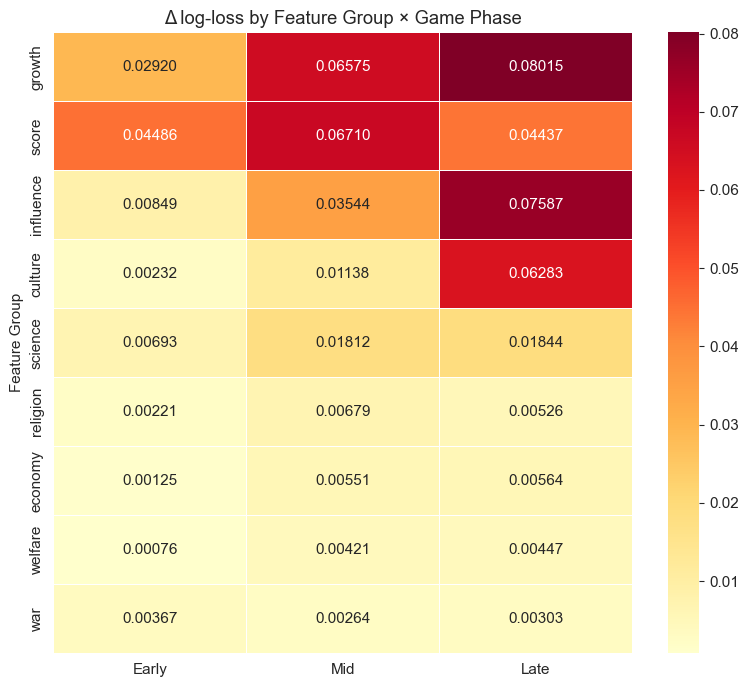

In [100]:
# Heatmap: group × game phase
phase_df = results_df[results_df['stratum'].isin(PHASE_LABELS)].copy()
phase_pivot = (phase_df.groupby(['group', 'stratum'])['delta_ll']
               .mean().unstack('stratum'))
phase_pivot = phase_pivot.loc[group_order, PHASE_LABELS]

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(phase_pivot, annot=True, fmt='.5f', cmap='YlOrRd',
            linewidths=0.5, ax=ax)
ax.set_title('Δ log-loss by Feature Group × Game Phase')
ax.set_ylabel('Feature Group')
ax.set_xlabel('')
plt.tight_layout()
plt.show()